<a href="https://colab.research.google.com/github/DayDreamChaser/torch-action/blob/main/BERT%E2%80%94%E2%80%94transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT文本分类

任务：微调BERT来处理文本情感分类任务

数据集：美团外卖的用户评论数据集

目标：把评论分成，好评(标签为1) 和 差评(标签为0)

In [1]:
#安装库
# !pip install datasets
# !pip install transformers[torch]
# !pip install torchkeras

## 一，准备数据

准备数据阶段主要需要用到的是datasets.Dataset 和transformers.AutoTokenizer。


### 1，数据加载

HuggingFace的datasets库提供了Dataset的功能。

In [2]:
import numpy as np
import pandas as pd
import datasets

import torch
from torch.utils.data import DataLoader

In [3]:
import urllib.request
import os

url_base = 'https://raw.githubusercontent.com/SophonPlus/ChineseNlpCorpus/master/datasets/waimai_10k/'
key_file = 'waimai_10k.csv'
dataset_dir = "data"


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")

_download(key_file)

In [4]:
df = pd.read_csv("data/waimai_10k.csv")
df = df.rename(columns={"label":"labels"})

In [5]:
df.loc[0]

labels               1
review    很快，好吃，味道足，量大
Name: 0, dtype: object

In [6]:
df.head(10)

,labels,review
0,1,很快，好吃，味道足，量大
1,1,没有送水没有送水没有送水
2,1,非常快，态度好。
3,1,方便，快捷，味道可口，快递给力
4,1,菜味道很棒！送餐很及时！
5,1,今天师傅是不是手抖了，微辣格外辣！
6,1,"送餐快,态度也特别好,辛苦啦谢谢"
7,1,超级快就送到了，这么冷的天气骑士们辛苦了。谢谢你们。麻辣香锅依然很好吃。
8,1,经过上次晚了2小时，这次超级快，20分钟就送到了……
9,1,最后五分钟订的，卖家特别好接单了，谢谢。


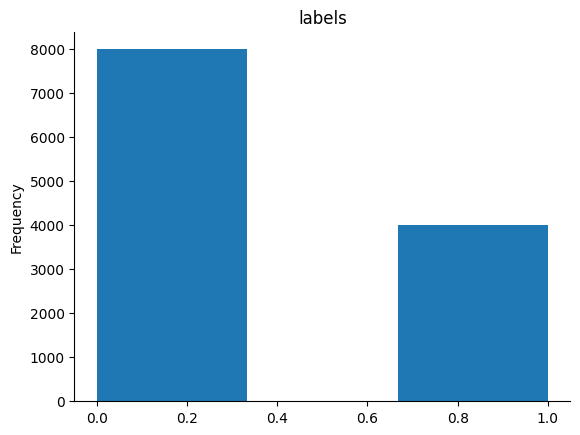

In [7]:
# @title label
from matplotlib import pyplot as plt
df['labels'].plot(kind='hist', bins=3, title='labels')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [8]:
df['len'] = df['review'].apply(len)
df['len'].describe()

count    11987.000000
mean        25.048553
std         24.680028
min          5.000000
25%         11.000000
50%         17.000000
75%         30.000000
max        463.000000
Name: len, dtype: float64

平均长度25.05， 中位数17， 上四分位30，最大463
取最大长度50截断

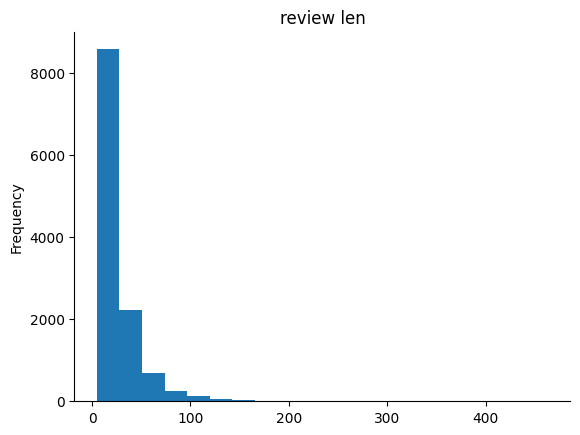

In [9]:
df['len'].plot(kind='hist', bins=20, title='review len')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [10]:
df[10:20]["review"]

10                量大，好吃，每次点的都够吃两次
11                     挺辣的，吃着还可以吧
12                    味道好，送餐快，分量足
13                     量足，好吃，送餐也快
14         特别好吃，量特大，而且送餐特别快，特别特别棒
15                     口感好的很，速度快！
16           相当好吃的香锅，分量够足，味道也没的说。
17    好吃！速度！包装也有品质，不出家门就能吃到餐厅的味道！
18                味道好极啦，送餐很快师傅辛苦啦
19                  量大味道好，送餐师傅都很好
Name: review, dtype: object

<Axes: title={'center': 'labels'}, ylabel='Frequency'>

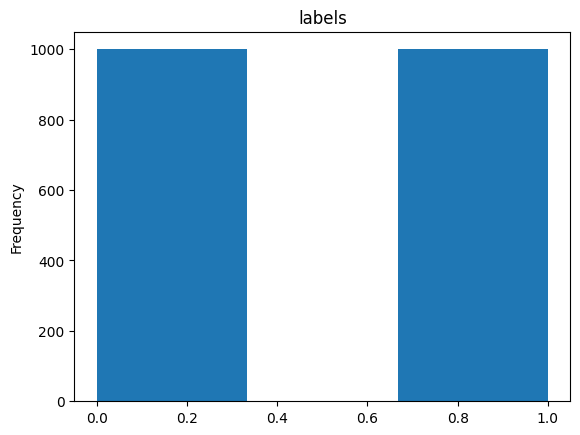

In [11]:
neg_df = df[df['labels']==0]
pos_df = df[df['labels']==1]

pos_df = pos_df.sample(n=1000, random_state=200)  # 1000条
neg_df = neg_df.sample(n=1000, random_state=200)  # 1000条
df = pd.concat([neg_df, pos_df], axis=0)

df['labels'].plot(kind='hist', bins=3, title='labels')

In [12]:
ds = datasets.Dataset.from_pandas(df)
ds

Dataset({
    features: ['labels', 'review', 'len', '__index_level_0__'],
    num_rows: 2000
})

### 2，文本分词

transformers库使用tokenizer进行文本分词。


In [13]:
from transformers import AutoTokenizer #BertTokenizer

model_id = "hfl/chinese-roberta-wwm-ext-large"
tokenizer = AutoTokenizer.from_pretrained(model_id) #需要和模型一致
print(tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BertTokenizerFast(name_or_path='hfl/chinese-roberta-wwm-ext-large', vocab_size=21128, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [22]:
#tokenizer可以使用 __call__,encode,encode_plus,batch_encode_plus等方法编码
#可以使用decode,batch_decode等方法进行解码
sample_txt = ds['review'][0]
print(sample_txt)
text_codes = tokenizer(text=sample_txt,
                       text_pair = None,
                       max_length = 100,
                       truncation = True,
                       padding= 'do_not_pad') #可选'longest','max_length','do_not_pad'

#input_ids是编码后的数字，token_type_ids表示来自第1个句子还是第2个句子
#attention_mask在padding的位置是0其它位置是1
print(text_codes)

一定不要点炒面,2小时终于坨成了石头
{'input_ids': [101, 671, 2137, 679, 6206, 4157, 4143, 7481, 117, 123, 2207, 3198, 5303, 754, 1789, 2768, 749, 4767, 1928, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [15]:
print(tokenizer.decode(text_codes["input_ids"][0]))
print(tokenizer.decode(text_codes["input_ids"][-1]))

[CLS]
[SEP]


In [24]:
tokenizer.batch_decode(text_codes["input_ids"])

['[CLS]',
 '一',
 '定',
 '不',
 '要',
 '点',
 '炒',
 '面',
 ',',
 '2',
 '小',
 '时',
 '终',
 '于',
 '坨',
 '成',
 '了',
 '石',
 '头',
 '[SEP]']

In [25]:
tokens = tokenizer.tokenize(sample_txt)
print("tokens=",tokens)

ids = tokenizer.convert_tokens_to_ids(tokens)
print("ids = ",ids)

tokens= ['一', '定', '不', '要', '点', '炒', '面', ',', '2', '小', '时', '终', '于', '坨', '成', '了', '石', '头']
ids =  [671, 2137, 679, 6206, 4157, 4143, 7481, 117, 123, 2207, 3198, 5303, 754, 1789, 2768, 749, 4767, 1928]


### 3，传入DataLoader

In [26]:
# 进行批量Tokenize
ds_encoded = ds.map(lambda x:tokenizer(x["review"], max_length=50, truncation=True, padding='max_length'),
                    batched=True,
                    batch_size=16,
                    num_proc=4) #支持批处理和多进程map

Map (num_proc=4):   0%|          | 0/2000 [00:00<?, ? examples/s]

In [27]:
#转换成pytorch中的tensor
ds_encoded.set_format(type="torch",
           columns = ["input_ids",'attention_mask','token_type_ids','labels'])

#ds_encoded.reset_format()
ds_encoded[0]

{'labels': tensor(0),
 'input_ids': tensor([ 101,  671, 2137,  679, 6206, 4157, 4143, 7481,  117,  123, 2207, 3198,
         5303,  754, 1789, 2768,  749, 4767, 1928,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0])}

In [28]:
#分割成训练集和测试集
ds_train_val, ds_test = ds_encoded.train_test_split(test_size=0.2).values()
ds_train, ds_val = ds_train_val.train_test_split(test_size=0.2).values()

print(ds_train, ds_val, ds_test)

Dataset({
    features: ['labels', 'review', 'len', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1280
}) Dataset({
    features: ['labels', 'review', 'len', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 320
}) Dataset({
    features: ['labels', 'review', 'len', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 400
})


In [30]:
#在collate_fn中可以做动态批处理(dynamic batching)
def collate_fn(examples):
    return tokenizer.pad(examples) #return_tensors='pt'

#以下方式等价
#from transformers import DataCollatorWithPadding
#collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

batch_size = 32
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, collate_fn = collate_fn)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=batch_size,  collate_fn = collate_fn)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size,  collate_fn = collate_fn)

In [32]:
for batch in dl_train:
  print(batch)
  break

{'labels': tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 1]), 'input_ids': tensor([[ 101, 4343, 5489,  ...,    0,    0,    0],
        [ 101, 3739, 6963,  ...,    0,    0,    0],
        [ 101, 7883, 5597,  ...,    0,    0,    0],
        ...,
        [ 101, 4636, 2428,  ...,  679,  671,  102],
        [ 101,  671,  819,  ...,    0,    0,    0],
        [ 101, 1348, 2563,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


## 二，定义模型

一个完整的模型(Model)包括模型架构(Architecture)和模型权重(Checkpoints/Weights)。

transformers提供了3种指定模型架构的方法。

* 第1种是指定模型架构(如: from transformers import BertModel)

* 第2种是自动推断模型架构(如: from transformers import AutoModel)

* 第3种是自动推断模型架构并自动添加Head (如: from transformers import AutoModelForSequenceClassification )

第1种方案和第2种方案用户可以灵活地根据自己要做的任务设计Head，并且需要对基础模型有一定的了解。


此处我们使用第3种方案。


In [33]:
from transformers import AutoModelForSequenceClassification

#加载模型 (会添加针对特定任务类型的Head)
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)

dict(model.named_children()).keys()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-roberta-wwm-ext-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


dict_keys(['bert', 'dropout', 'classifier'])

In [34]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

我们可以用一个batch的数据去试算一下

In [37]:
model = model.to(device)
output = model(**batch.to(device))

In [38]:
output.loss

tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward0>)

In [39]:
output

SequenceClassifierOutput(loss=tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[ 0.2274,  0.0879],
        [ 0.2534, -0.0826],
        [ 0.2366,  0.1563],
        [ 0.3862,  0.0725],
        [ 0.1837,  0.1254],
        [ 0.2206, -0.1636],
        [ 0.3930,  0.0513],
        [ 0.3388, -0.1072],
        [ 0.2994, -0.0508],
        [ 0.2531, -0.0265],
        [ 0.4523,  0.0403],
        [ 0.2359,  0.1121],
        [ 0.4592, -0.0588],
        [ 0.2201, -0.0724],
        [ 0.2708,  0.1066],
        [ 0.3107, -0.0762],
        [ 0.1405,  0.1901],
        [ 0.2418,  0.0127],
        [ 0.2504,  0.1760],
        [ 0.3721,  0.2222],
        [ 0.2607, -0.0076],
        [ 0.3155,  0.0731],
        [ 0.1676,  0.0458],
        [ 0.1966, -0.1905],
        [ 0.2911,  0.1291],
        [ 0.2567,  0.1316],
        [ 0.3107,  0.0167],
        [ 0.2838,  0.0387],
        [ 0.4149,  0.0059],
        [ 0.1522,  0.0682],
        [ 0.2589,  0.1399],
        [ 0.1181, -0.2881]], devic

## 三，训练模型

In [ ]:
!pip install accelerate

下面使用我们的梦中情炉 torchkeras 来实现最优雅的微调训练循环。🤗🤗



In [40]:
from torchkeras import KerasModel

#我们需要修改StepRunner以适应transformers的数据集格式

class StepRunner:
    def __init__(self, net, loss_fn, accelerator, stage = "train", metrics_dict = None,
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator
        if self.stage=='train':
            self.net.train()
        else:
            self.net.eval()

    def __call__(self, batch):

        out = self.net(**batch.to(device))

        #loss
        loss = out.loss

        #preds
        preds =(out.logits).argmax(axis=1)

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()

        all_loss = self.accelerator.gather(loss).sum()

        labels = batch['labels']
        acc = (preds==labels).sum()/((labels>-1).sum())

        all_acc = self.accelerator.gather(acc).mean()

        #losses
        step_losses = {self.stage+"_loss":all_loss.item(), self.stage+'_acc':all_acc.item()}

        #metrics
        step_metrics = {}

        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics

KerasModel.StepRunner = StepRunner

In [41]:
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
keras_model = KerasModel(model,loss_fn=None,optimizer = optimizer)

<<<<<< ⚡️ cuda is used >>>>>>


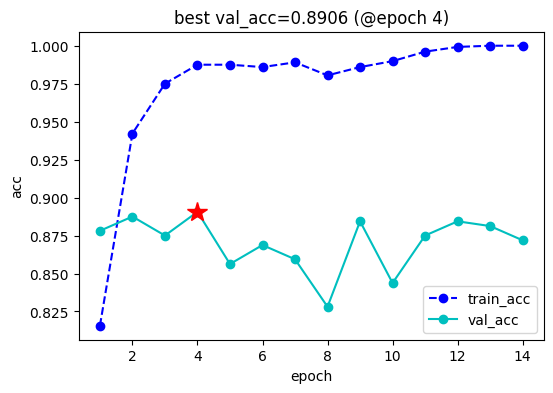

<<<<<< val_acc without improvement in 10 epoch,early stopping >>>>>> 



,epoch,train_loss,train_acc,lr,val_loss,val_acc
0,1,0.400042,0.815625,0.00003,0.298466,0.878125
1,2,0.178673,0.942187,0.00003,0.293229,0.887500
2,3,0.079503,0.975000,0.00003,0.435754,0.875000
3,4,0.047774,0.987500,0.00003,0.483032,0.890625
4,5,0.030902,0.987500,0.00003,0.593966,0.856250
5,6,0.044966,0.985938,0.00003,0.639174,0.868750
6,7,0.044582,0.989062,0.00003,0.647959,0.859375
7,8,0.073322,0.980469,0.00003,0.604683,0.828125
8,9,0.040865,0.985938,0.00003,0.535952,0.884375
9,10,0.036645,0.989844,0.00003,0.567870,0.843750


In [42]:
keras_model.fit(
    train_data = dl_train,
    val_data= dl_val,
    ckpt_path='bert_waimai.pt',
    epochs=20,
    patience=10,
    monitor="val_acc",
    mode="max",
    plot = True,
    wandb = False,
    quiet = True
)


## 四，评估模型

可以使用huggingFace的evaluate库来进行模型评估。

通过evaluate的load方法可以加载一些常用的评估指标。

可以用add_batch逐批次地往这些评估指标上添加数据，最后用compute计算评估结果。

In [43]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


In [46]:
import evaluate
metric = evaluate.load("accuracy")
model.eval()
model = model.to(device)

dl_test = keras_model.accelerator.prepare(dl_test)
for batch in dl_test:
    with torch.no_grad():
        outputs = model(**batch.to(device))

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.8975}

## 五，使用模型

In [47]:
texts = ["今天师傅是不是手抖了，微辣格外辣 ","这他妈也太难吃了吧","没有送水没有送水没有送水","还行吧"]
batch = tokenizer(texts, padding=True, return_tensors="pt")
batch = {k:v.to(keras_model.accelerator.device) for k,v in batch.items()}

In [48]:
from torch import nn
logits = model(**batch).logits
scores = nn.Softmax(dim=-1)(logits)[:,-1]
print(scores)
#可以看到得分与人的预期是高度一致的

tensor([2.2612e-02, 7.8786e-04, 5.4986e-04, 9.7478e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)


也可以用pipeline把tokenizer和model组装在一起

In [49]:
from transformers import pipeline
classifier = pipeline(task="text-classification", tokenizer=tokenizer, model=model.cpu())
classifier("挺好吃的哦")

[{'label': 'LABEL_1', 'score': 0.9840770959854126}]

## 六，保存模型

保存model和tokenizer之后，我们可以用一个pipeline加载，并进行批量预测。


In [50]:
model.config.id2label = {0:"差评",1:"好评"}
model.save_pretrained("waimai_10k_bert")
tokenizer.save_pretrained("waimai_10k_bert")

('waimai_10k_bert/tokenizer_config.json',
 'waimai_10k_bert/special_tokens_map.json',
 'waimai_10k_bert/vocab.txt',
 'waimai_10k_bert/added_tokens.json',
 'waimai_10k_bert/tokenizer.json')

In [51]:
from transformers import pipeline
classifier = pipeline("text-classification",model="waimai_10k_bert")


In [52]:
classifier(["味道还不错，下次再来","我去，吃了我吐了三天"])

[{'label': '好评', 'score': 0.9777551293373108},
 {'label': '差评', 'score': 0.9994437098503113}]

In [53]:
classifier(["用户：你好，我想买点理财","想鼓励一下作者杀人"])

[{'label': '好评', 'score': 0.9777470231056213},
 {'label': '差评', 'score': 0.8687992691993713}]